In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
import random
import colorsys
import time
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input
from core.config import *
from core.yolov4 import *

YOLO_STRIDES                = [8, 16, 32]
STRIDES         = np.array(YOLO_STRIDES)
ANCHORS         = (np.array(YOLO_ANCHORS).T/STRIDES).T

def detect_image(Yolo, image_path, output_path, input_size=416, show=False, 
                CLASSES=YOLO_COCO_CLASSES, 
                score_threshold=0.25, iou_threshold=0.35, 
                rectangle_colors=''):
    original_image      = cv2.imread(image_path)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    #original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)

    if YOLO_FRAMEWORK == "tf":
        pred_bbox = Yolo.predict(image_data, verbose=0)
    elif YOLO_FRAMEWORK == "trt":
        batched_input = tf.constant(image_data)
        result = Yolo(batched_input)
        pred_bbox = []
        for key, value in result.items():
            value = value.numpy()
            pred_bbox.append(value)
        
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    #print(pred_bbox)
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
    #print(len(bboxes))
    bboxes = nms(bboxes, iou_threshold, method='nms')
    print(bboxes)
    """print(bboxes)
    bboxes = np.array(bboxes) 
    bboxes = bboxes[bboxes[:, 5]== 1]"""
    bboxes = merge_bboxes(bboxes)

    image = draw_bbox(original_image, bboxes, CLASSES=CLASSES,show_label=True, 
                    show_confidence = False, rectangle_colors=rectangle_colors)
    # CreateXMLfile("XML_Detections", str(int(time.time())), original_image, bboxes, read_class_names(CLASSES))

    if output_path != '': cv2.imwrite(output_path, image)
    if show:
        # Show the image
        cv2.imshow("predicted image", image)
        # Load and hold the image
        cv2.waitKey(0)
        # To close the window after the required kill value was provided
        cv2.destroyAllWindows()
        
    return image, bboxes

def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

def draw_bbox(image, bboxes, CLASSES=YOLO_COCO_CLASSES, show_label=True, 
show_confidence = True, Text_colors=(255,255,0), rectangle_colors='', tracking=False):   
    NUM_CLASS = read_class_names(CLASSES)
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != '' else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        if bbox_thick < 1: bbox_thick = 1
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            score_str = " {:.2f}".format(score) if show_confidence else ""

            if tracking: score_str = " "+str(score)

            try:
                label = "{}".format(NUM_CLASS[class_ind]) + score_str
            except KeyError:
                print("You received KeyError, this might be that you are trying to use yolo original weights")
                print("while using custom classes, if using custom model in configs.py set YOLO_CUSTOM_WEIGHTS = True")

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        # Process 1: Determine whether the number of bounding boxes is greater than 0 
        while len(cls_bboxes) > 0:
            # Process 2: Select the bounding box with the highest score according to socre order A
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            # Process 3: Calculate this bounding box A and
            # Remain all iou of the bounding box and remove those bounding boxes whose iou value is higher than the threshold 
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

def image_preprocess(image, target_size, gt_boxes=None):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

def read_class_names(class_file_name):
    # loads class name from a file
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

def decode(conv_output, NUM_CLASS, i=0):
    # where i = 0, 1 or 2 to correspond to the three grid scales  
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    #conv_raw_dxdy = conv_output[:, :, :, :, 0:2] # offset of center position     
    #conv_raw_dwdh = conv_output[:, :, :, :, 2:4] # Prediction box length and width offset
    #conv_raw_conf = conv_output[:, :, :, :, 4:5] # confidence of the prediction box
    #conv_raw_prob = conv_output[:, :, :, :, 5: ] # category probability of the prediction box
    conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = tf.split(conv_output, (2, 2, 1, NUM_CLASS), axis=-1)

    # next need Draw the grid. Where output_size is equal to 13, 26 or 52  
    #y = tf.range(output_size, dtype=tf.int32)
    #y = tf.expand_dims(y, -1)
    #y = tf.tile(y, [1, output_size])
    #x = tf.range(output_size,dtype=tf.int32)
    #x = tf.expand_dims(x, 0)
    #x = tf.tile(x, [output_size, 1])
    xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
    xy_grid = tf.expand_dims(tf.stack(xy_grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    xy_grid = tf.tile(tf.expand_dims(xy_grid, axis=0), [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)
    
    #xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    #xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    #y_grid = tf.cast(xy_grid, tf.float32)

    # Calculate the center position of the prediction box:
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    # Calculate the length and width of the prediction box:
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf) # object box calculates the predicted confidence
    pred_prob = tf.sigmoid(conv_raw_prob) # calculating the predicted probability category box object

    # calculating the predicted probability category box object
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

def Create_Yolo(input_size=416, channels=3, training=False, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    input_layer  = Input([input_size, input_size, channels])

    if TRAIN_YOLO_TINY:
        if YOLO_TYPE == "yolov4":
            conv_tensors = YOLOv4_tiny(input_layer, NUM_CLASS)
        if YOLO_TYPE == "yolov3":
            conv_tensors = YOLOv3_tiny(input_layer, NUM_CLASS)
    else:
        if YOLO_TYPE == "yolov4":
            conv_tensors = YOLOv4(input_layer, NUM_CLASS)
        if YOLO_TYPE == "yolov3":
            conv_tensors = YOLOv3(input_layer, NUM_CLASS)

    output_tensors = []
    for i, conv_tensor in enumerate(conv_tensors):
        pred_tensor = decode(conv_tensor, NUM_CLASS, i)
        if training: output_tensors.append(conv_tensor)
        output_tensors.append(pred_tensor)

    Yolo = tf.keras.Model(input_layer, output_tensors)
    return Yolo

2022-06-20 13:31:59.721396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
yolo = Create_Yolo(input_size=224, CLASSES=TRAIN_CLASSES)
yolo.load_weights(f"./checkpoints/clock/yolov4") # use keras weights

In [6]:
from predictionLib.predictionLib import mergeDigits
import matplotlib.pyplot as plt

[array([113.25765991, 227.79031372, 143.88519287, 267.7883606 ,
         0.98183435,   0.        ]), array([ 91.14680481, 227.3870697 , 123.13890839, 267.75344849,
         0.97452253,   1.        ]), array([135.42515564, 136.26565552, 164.57484436, 176.26190186,
         0.97393948,   1.        ]), array([239.9947052 ,  78.98578644, 274.29101562, 119.89700317,
         0.97232491,   1.        ]), array([158.98149109, 135.99476624, 183.87565613, 176.20957947,
         0.96730018,   1.        ]), array([367.40304565, 135.56214905, 404.0255127 , 176.21403503,
         0.95304281,   1.        ]), array([263.54431152,  79.31546021, 293.59854126, 119.57064819,
         0.98297691,   2.        ]), array([408.24472046, 188.52641296, 448.89813232, 229.35021973,
         0.96412832,   2.        ]), array([434.97875977, 272.30609131, 465.02124023, 312.59262085,
         0.97619069,   3.        ]), array([450.88323975, 351.12240601, 491.97390747, 392.77380371,
         0.97503686,   4.        ]),

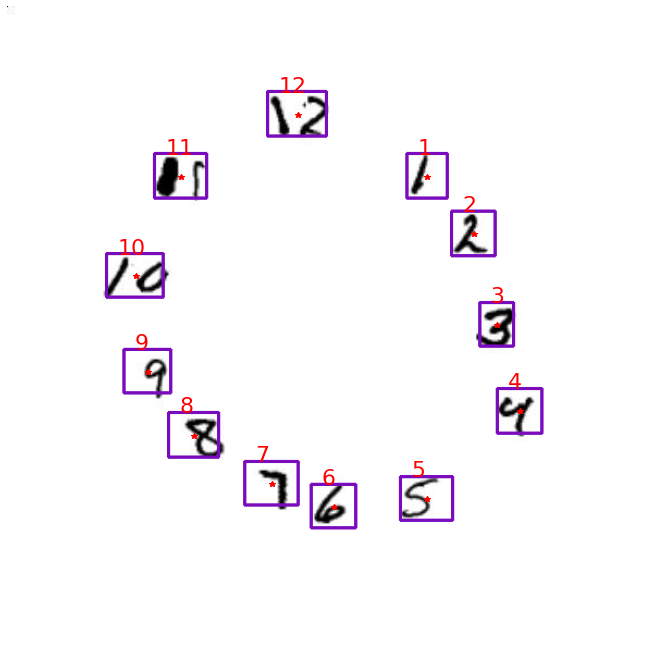

In [9]:
ID = 1
label_txt = "clockNumData/test.txt"
image_info = open(label_txt).readlines()[ID].split()
image_path = image_info[0]

image_path = f'./clockNumData/test/{ID}_clockDigit.jpg';
image_path = '../Clock-Drawing-Test/DATA/1600/567_clockDigit.jpg';
#image_path = f'./clockNumData/1388_clockDigit.jpg';
img, bboxes = detect_image(yolo, image_path, "txt.jpg", input_size=224, show=False, 
                CLASSES=TRAIN_CLASSES, rectangle_colors=(125,0,0));

rects = []
predNums = []
for rect in bboxes:
    predNums.append(rect[5])
    rects.append([rect[0], rect[1], rect[2] - rect[0], rect[3] - rect[1]])
    
acceptedRects, mergedPrediction = mergeDigits(rects, predNums)
overlapMatrix = mergeRects(acceptedRects)
idxArr = np.where(overlapMatrix > 0.8)[0]
#s = np.array([9,2,3,4, 10])
idxArr[::-1].sort()
for idx in idxArr:
    mergedPrediction.pop(idx)
    acceptedRects.pop(idx)

image= cv2.imread(image_path)
plt.figure(figsize=(12,12))
for rect, digitPre in zip(acceptedRects, mergedPrediction):
        x = rect[0] + rect[2] / 2
        y = rect[1] + rect[3] / 2
        cv2.rectangle(image, (int(rect[0]), int(rect[1])), (int(rect[0] + rect[2]),
                            int(rect[1] + rect[3])),  color= (121, 11, 189),  
                            thickness=2)
        #print(x, y)
        plt.plot(x, y, '*', color='red')
        point = (int(rect[0] + 10), int(rect[1]))
        #print(x, y)
        plt.plot(x, y, '*', color='red')
        plt.annotate(str(int(digitPre)),
         xy=point, fontsize = 22, color = 'red')
plt.imshow(image, cmap="gray")
#plt.imshow(img)
plt.axis('off');
print(mergedPrediction)


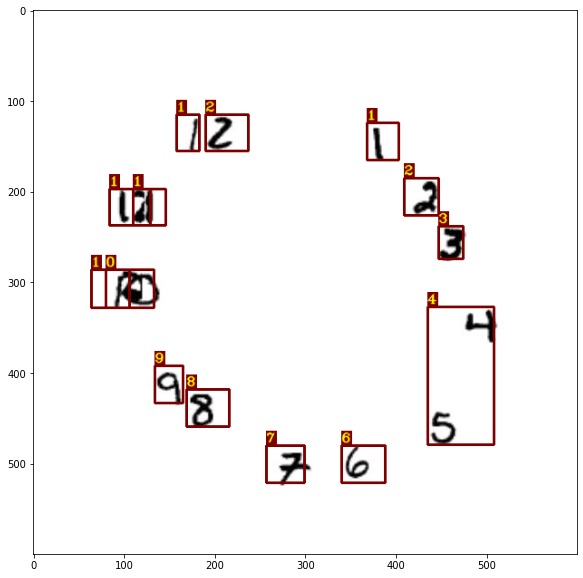

In [390]:
plt.figure(figsize=(10,10))
plt.imshow(img)

In [2]:
def overlap_rect(rect1, rect2):
    x1 = max(rect1[0], rect2[0])
    y1 = max(rect1[1], rect2[1])

    x2 = min(rect1[0] + rect1[2], rect2[0] + rect2[2])
    y2 = min(rect1[1] + rect1[3], rect2[1] + rect2[3])
    if x2 > x1 and y2 > y1:
        return np.array([x1, y1, x2, y2])
    else:
        return [0, 0, 0, 0]

def mergeRects(rects):
    rectsLen = len(rects)
    overlapMatrix = np.zeros((rectsLen, rectsLen))
    for i in range(rectsLen - 1):
        for j in range(i+1, rectsLen):
            overlaprect = overlap_rect(rects[i], rects[j])
            overlapA = box_area(overlaprect)
            if overlapA < 0:
                continue
            bA1 = rects[i][2] * rects[i][3]
            bA2 = rects[j][2] * rects[j][3]
            if overlapA / bA1 > overlapA / bA2:
                overlapMatrix[i,j] = overlapA / bA1
            else: 
                overlapMatrix[j,i] = overlapA / bA2
    return overlapMatrix
    


In [3]:
def box_area(box):
    return (box[3] - box[1]) * (box[2] - box[0])

def overlap_box(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])

    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x2 > x1 and y2 > y1:
        bboxesConf = [box1[4], box2[4]]
        bboxesNum  = [box1[5], box2[5]]
        idx = np.argmax(bboxesConf)
        return np.array([x1, y1, x2, y2, bboxesConf[idx], bboxesNum[idx]])
    else:
        return [0, 0, 0, 0, -1, -1]

def outJoin_box(box1, box2):
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])

    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    return np.array([x1, y1, x2, y2, box1[4], box1[5]])

def merge_bboxes(bboxes):
    bboxesSize = len(bboxes) + 1
    if bboxesSize <= 1:
        return bboxes
    while len(bboxes) < bboxesSize:
        bboxesSize = len(bboxes)
        overlapMatrix = np.zeros((bboxesSize, bboxesSize))
        for i in range(bboxesSize - 1):
            for j in range(i+1, bboxesSize):
                if bboxes[i][5] != bboxes[j][5]:
                    continue
                
                overlapBox = overlap_box(bboxes[i], bboxes[j])
                overlapA = box_area(overlapBox)
                if overlapA < 0:
                    continue
                bA1 = box_area(bboxes[i])
                bA2 = box_area(bboxes[j])
                overlapP = max(overlapA / bA1, overlapA / bA2) 
                if  overlapP >= 0.8:
                    overlapMatrix[i,j] = overlapP
                if bboxes[i][5] != 1:
                    overlapMatrix[i,j] = overlapP

        idx = np.argmax(overlapMatrix)
        rowI = idx // bboxesSize
        colI = idx % bboxesSize
        #print(bboxes)
        if np.max(overlapMatrix) > 0.5:
            #print(bboxes[rowI][5], bboxes[colI][5])
            overlapBox = overlap_box(bboxes[rowI], bboxes[colI])
            bboxes.pop(colI)
            bboxes.pop(rowI)
            bboxes.append(overlapBox)
        elif np.max(overlapMatrix) > 0.35:
            #print(bboxes[rowI][5], bboxes[colI][5])
            overlapBox = outJoin_box(bboxes[rowI], bboxes[colI])
            #print(bboxes[rowI][5], bboxes[colI][5])
            bboxes.pop(colI)
            bboxes.pop(rowI)
            bboxes.append(overlapBox)

        #print(bboxes[5:9])
            
    return bboxes


In [ ]:
rects = np.array([[5,3], [2, 9], [3, 8]])
Ys = []
for rect in rects:
    Ys.append(rect[0])
sortedIdx = np.argsort(Ys)
rects = rects[sortedIdx]
rects

array([[2, 9],
       [3, 8],
       [5, 3]])

In [4]:
def mergeDigits(rects, prediction):
    # Just initialize bounding rects and set all bools to false
    rects = np.array(rects)
    prediction = np.array(prediction)
    
    rectsUsed = []
    digitXs = []
    for cnt in rects:
        rectsUsed.append(False)
        digitXs.append(cnt[0] + cnt[2] )
    
    sortedIdx = np.argsort(digitXs)
    # Sort bounding rects by x coordinate
    
    rects = rects[sortedIdx]
    prediction = prediction[sortedIdx]
    print(prediction)
    # Array of accepted rects
    acceptedRects = []
    mergedPrediction = []
    
    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if rectsUsed[supIdx]:
            continue
        mergedDigit = prediction[supIdx]
        # Initialize current rect
        currxMin = supVal[0]
        currxMax = supVal[0] + supVal[2] #/ 2
        curryMin = supVal[1]
        curryMax = supVal[1] + supVal[3]

        # This bounding rect is used
        rectsUsed[supIdx] = True

        digitW = supVal[2]
        # Iterate all initial bounding rects
        # starting from the next
        for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):
            if rectsUsed[subIdx]:
                continue
            # Initialize merge candidate
            candxMin = subVal[0]
            candxMax = subVal[0] + subVal[2]#/2
            candyMin = subVal[1]
            candyMax = subVal[1] + subVal[3]

            # Check if x distance between current rect
            # and merge candidate is small enough and if merged result is 
            #larger than 25, it should not be merged
            #if digit is 11, they can be seperated farer than others
            dThr = max(supVal[3], subVal[3] , supVal[2], subVal[2])
            xThr = dThr / 2
            yThr = dThr / 3
            if prediction[supIdx] == 1:
                xThr =  dThr
            
            #the smaller digit should be within the height of the large one, if these two can be 
            #merged
            #print(np.abs(candxMin - currxMax), xThr)
            #print(np.abs(candyMax-curryMax), yThr)
            if prediction[supIdx] == 1 and prediction[subIdx] == 3:
                print(np.abs(candxMin - currxMax) <=  xThr)
            if (np.abs(candxMin - currxMax) <=  xThr) and \
                ((np.abs(candyMax-curryMax) <= yThr) or (np.abs(candyMin-curryMin) <= yThr)) and \
                prediction[supIdx] * 10 + prediction[subIdx] < 25:
                
                overlapMin = max(curryMin, candyMin)
                overlapMax = min(curryMax, candyMax)
                if (overlapMax - overlapMin) / min(subVal[3], supVal[3]) < 0.85 and candxMin - currxMax >=  5:
                    continue
                if (overlapMax - overlapMin) / min(subVal[3], supVal[3]) < 0.7:
                    continue
                    
                mergedDigit = prediction[supIdx] * 10  + prediction[subIdx]
                currxMin = min(candxMin, currxMin)
                currxMax = max(candxMax, currxMax)
                curryMin = min(curryMin, candyMin)
                curryMax = max(curryMax, candyMax)

                # Merge candidate (bounding rect) is used
                digitW = subVal[0] + subVal[2] - currxMin
                rectsUsed[subIdx] = True
                break
            # No more merge candidates possible, accept current rect
            #if currxMax-currxMin <= dThr/4:
            #    continue

        mergedPrediction.append(mergedDigit)
        acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])
    return acceptedRects, mergedPrediction
